# XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of the gradient boosting algorithm. It is widely used for supervised learning tasks such as classification and regression. XGBoost builds an ensemble of decision trees in a sequential manner, where each tree attempts to correct the errors of the previous ones. Key features include:

- **Gradient Boosting**: Optimizes a loss function by adding weak learners (decision trees) iteratively.
- **Regularization**: Includes L1 and L2 regularization to prevent overfitting.
- **Parallelization**: Supports parallel computation to speed up training.
- **Handling Missing Values**: Automatically learns the best way to handle missing data.
- **Custom Objective Functions**: Allows users to define their own loss functions.

In this notebook, XGBoost is used to classify images into different categories based on extracted features. You can check the [documentation](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for more details.

In [1]:
%load_ext autoreload
%autoreload 2

In [295]:
# imports and path setup
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import tqdm
from joblib import Parallel, delayed, parallel_backend
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from userkits.features import *
from userkits.utils import *

## Load and Shuffle Data

In [169]:
HALF_SIZE = False

In [170]:
# load data from train and eval directories
# set half=True to resize images to half to reduce memory usage
X, y = load_train_data(data_dir='../train_data_cropped', half=HALF_SIZE)
X, y = shuffle(X, y, random_state=42)


























































































































Loading train data: 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]


## Transform Data and Add Features

The steps to include new features are detailed in (the file). You can find the definitions of currently included features there.

In [ ]:
# def process_image(img):
#     feats = []
#     # add feature functions here
#     feats.extend(color_histogram(img))
#     feats.extend(lbp_texture_features(img))
#     feats.extend(find_mean(img))
#     feats.extend(find_stddev(img))

#     feats.append(green_pixel_ratio(img))
#     feats.append(edge_density(img))
#     feats.append(extra_features(img))

#     return feats

# def extract_features(images):
#     feats = []
#     for img in X:
#         f = feature_check(img)
#         feats.append(f)
#     # This guarantees .shape is available and is (n_samples, n_features)
#     return np.vstack(feats)


In [ ]:
# def extract_features(images):
#     features_list = []
    
#     def process_image(img):
#         feats = []
#         feats.append(green_pixel_ratio(img))
#         feats.append(feature_check(img))
#         return feats

#     features_list = Parallel(n_jobs=-1)(delayed(process_image)(img) for img in tqdm.tqdm(images, desc="Extracting features"))
#     return np.vstack(features_list)

In [ ]:
# def process_image(img_bgr):
#     img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#     gray    = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

#     hist = rgb_color_hist(img_rgb)
#     lbp  = lbp_uniform_hist(gray)
#     e    = edge_density(gray)
#     V,S  = hsv_stats(img_rgb)

#     return np.hstack([hist, lbp, [e, V, S]]).astype(np.float32)


# def extract_features(images, n_jobs=-1, strict=True):
#     """
#     Map process_image over images. Returns (N, 528).
#     Set strict=False to fill failures with NaNs instead of raising.
#     """
#     # probe expected dim
#     probe = process_image(images[0])
#     D = probe.size

#     def _safe(img):
#         try:
#             v = process_image(img)
#             if v.size != D:
#                 raise ValueError(f"feature length {v.size} != expected {D}")
#             return v
#         except Exception:
#             if strict:
#                 raise
#             return np.full(D, np.nan, dtype=np.float32)

#     feats = Parallel(n_jobs=n_jobs)(
#         delayed(_safe)(img) for img in images
#     )
#     arr = np.vstack(feats)
#     if arr.shape[1] != D:
#         raise ValueError(f"Unexpected feature shape {arr.shape}; expected (N, {D}).")
#     return arr

In [294]:
def process_image(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray    = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    hist = rgb_color_hist(img_rgb)        # 512 (you already had this)
    lbp  = lbp_uniform_hist(gray)         # 10
    e    = edge_density(gray)             # 1
    V,S  = hsv_stats(img_rgb)             # 2

    # h16  = hue_hist16(img_rgb)            # 16
    # lab6 = lab_color_moments(img_rgb)     # 6
    # br4  = biome_ratios(img_rgb)          # 4

    return np.hstack([hist, lbp, [e, V, S], h16, lab6, br4]).astype(np.float32)


def extract_features(images, n_jobs=-1, strict=True):
    """
    Map process_image over images. Returns (N, 528).
    Set strict=False to fill failures with NaNs instead of raising.
    """
    # probe expected dim
    probe = process_image(images[0])
    D = probe.size

    def _safe(img):
        try:
            v = process_image(img)
            if v.size != D:
                raise ValueError(f"feature length {v.size} != expected {D}")
            return v
        except Exception:
            if strict:
                raise
            return np.full(D, np.nan, dtype=np.float32)

    feats = Parallel(n_jobs=n_jobs)(
        delayed(_safe)(img) for img in images
    )
    arr = np.vstack(feats)
    if arr.shape[1] != D:
        raise ValueError(f"Unexpected feature shape {arr.shape}; expected (N, {D}).")
    return arr

In [291]:
X_features = extract_features(X)
X_features.shape

(1483, 528)

In [283]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## Common hyperparameters
- `learning_rate`: Controls the step size at each iteration while moving toward a minimum of the loss function. Default is 0.1.
- `max_depth`: Maximum depth of a tree. Increasing this value makes the model more complex and likely to overfit. Default is 5.
- `n_estimators`: Number of gradient boosted trees. Equivalent to the number of boosting rounds. Default is 100.
- `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child. Used to control overfitting. Default is 1.
- `subsample`: Fraction of samples used for fitting the individual base learners. Default is 1.0.
- `colsample_bytree`: Fraction of features used for fitting individual trees. Default is 1.0.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node. Default is 0.

Train Accuracy: 1.0
Test Accuracy: 0.9090909090909091
Overall Accuracy (test): 0.9091

Per-biome results:


,precision,recall,f1-score,support
bamboo_jungle,0.888889,1.000000,0.941176,8.000000
beach,1.000000,1.000000,1.000000,7.000000
birch_forest,0.500000,0.800000,0.615385,5.000000
dark_forest,1.000000,1.000000,1.000000,13.000000
desert,1.000000,1.000000,1.000000,10.000000
forest,1.000000,1.000000,1.000000,7.000000
gravelly_mountains+,1.000000,1.000000,1.000000,6.000000
jungle,0.600000,1.000000,0.750000,6.000000
jungle_edge,0.727273,1.000000,0.842105,8.000000
jungle_hills,1.000000,0.714286,0.833333,14.000000


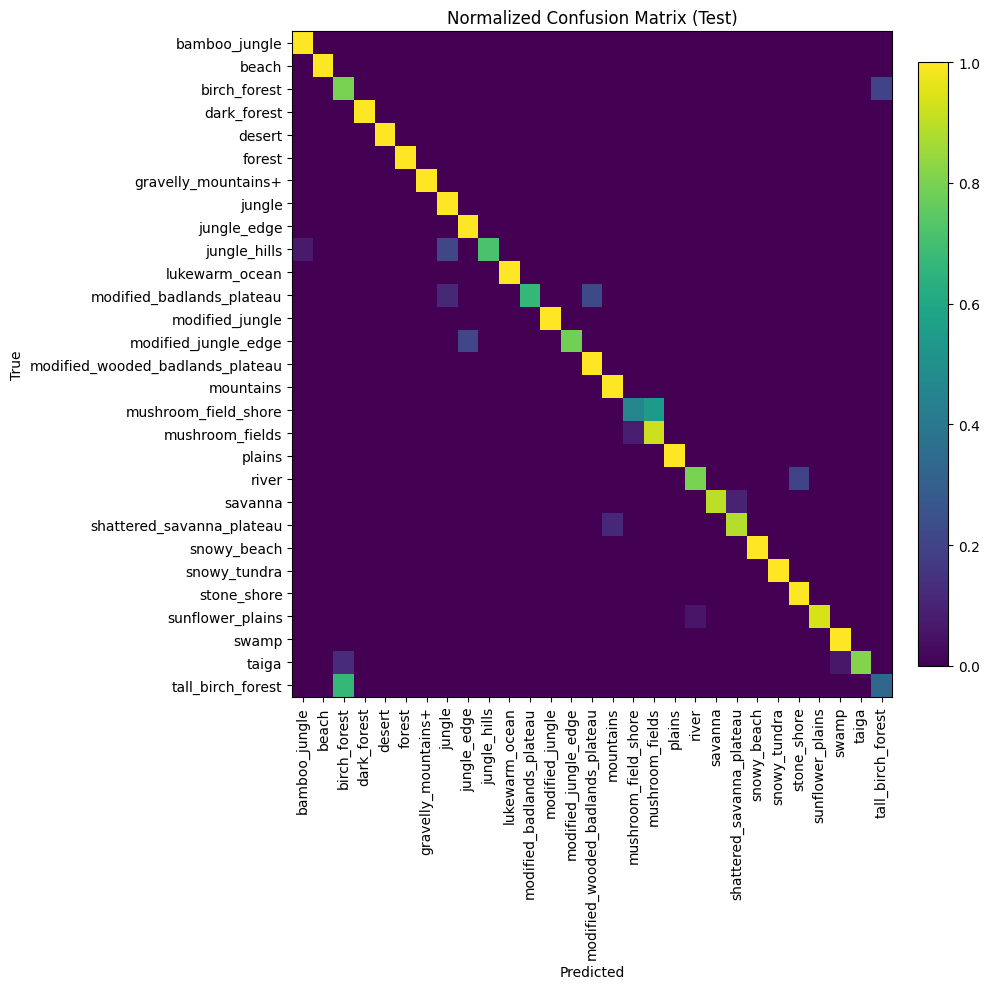

In [ ]:
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2)  # you can change test_size
clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
)  # you can tune hyperparameters here
clf.fit(X_train, y_train)
print("Train Accuracy:", clf.score(X_train, y_train))
print("Test Accuracy:", clf.score(X_test, y_test))

# === Biome classification evaluation (drop-in cell) ===

# 1) Predict on your held-out test split
y_pred = clf.predict(X_test)

# 2) Overall accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy (test): {acc:.4f}")

# 3) Per-biome metrics (precision/recall/F1/support)
# Map integer labels back to biome names
try:
    classes = label_encoder.classes_
    target_names = list(classes)
except Exception:
    # Fallback if no encoder is present (rare given your code)
    target_names = [str(i) for i in sorted(np.unique(y_test))]

report_dict = classification_report(
    y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0
)
per_biome = (
    pd.DataFrame(report_dict)
      .transpose()
      .loc[target_names + ["accuracy", "macro avg", "weighted avg"]]
)

print("\nPer-biome results:")
display(per_biome)

# 4) Confusion matrix (normalized by true class)
cm = confusion_matrix(y_test, y_pred, labels=range(len(target_names)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm_norm, aspect="auto")
ax.set_xticks(range(len(target_names)))
ax.set_yticks(range(len(target_names)))
ax.set_xticklabels(target_names, rotation=90)
ax.set_yticklabels(target_names)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Normalized Confusion Matrix (Test)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## Evaluate

In [242]:
# load eval data
# set half=True to resize images to half to reduce memory usage
X_eval, file_ids = load_eval_data("../eval_data_cropped", half=HALF_SIZE) 

Loading eval data: 100%|██████████| 1486/1486 [00:13<00:00, 114.13it/s]


In [292]:
X_eval_features = extract_features(X_eval)
eval_predictions = clf.predict(X_eval_features)
print(eval_predictions[:5])

ValueError: Feature shape mismatch, expected: 531, got 528

In [254]:
try:
    preds = label_encoder.inverse_transform(eval_predictions)
except Exception:
    preds = eval_predictions

save_predictions(preds, file_ids, output_file='../output/xgboost_predictions.csv')

Saved ../output/xgboost_predictions.csv
